# Load the requirement files

Note: The files shown below can be downloaded from the outputs section of the kaggle notebook.

In [1]:
pip install /kaggle/input/my-requirement-files/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl # installing dicom library

Processing /kaggle/input/my-requirement-files/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
# code below is used to load the EfficientNet library
import sys
sys.path.append('/kaggle/input/library-load/efficientnet_pytorch-0.7.1') 

# Import Libraries

In [3]:
import os
import cv2 # for resizing images
import torch # for pytorch framework
import dicomsdl # for reading dicom files
import numpy as np
import pandas as pd
import seaborn as sns # for visualization
from PIL import Image # to preprocess and transform images 
import torch.nn as nn # for defining custom neural network modules
import tensorflow as tf # tensorflow framework
import torch.optim as optim # for defining our optimizer
import matplotlib.pyplot as plt
from torchvision import transforms # for image transformation and augmentation
from torch.utils.data import Dataset # to create custom dataset in pytorch 
from torch.utils.data import DataLoader # provides an interface for batching and iterating over a dataset object
from efficientnet_pytorch import EfficientNet # for loading the efficient net pre-trained model
from torchvision.transforms import ToPILImage # for visualizing output of neural network
from sklearn.model_selection import train_test_split # create training and validation sets

%matplotlib inline

# Global Variable Declaration

In [4]:
# image re-size dimensions
target_size = [224,224]

# batch size for train data
batch_size = 16 
# batch size for test data
test_batch_size = 32 

# number of epochs
num_epochs = 6 

# Read Data

In [5]:
data_dir = '/kaggle/input/rsna-breast-cancer-detection'

In [6]:
train_df = pd.read_csv(f"{data_dir}/train.csv")

train_df['dcm_path'] = train_df.apply(
    lambda i: os.path.join(
        f"{data_dir}", 'train_images', str(i['patient_id']), str(i['image_id']) + '.dcm'
    ), axis=1
)
print(train_df.shape)
train_df.head(2)

(54706, 15)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,dcm_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...


In [7]:
test_df = pd.read_csv(f"{data_dir}/test.csv")

test_df['dcm_path'] = test_df.apply(
    lambda i: os.path.join(
        f"{data_dir}", 'test_images', str(i['patient_id']), str(i['image_id']) + '.dcm'
    ), axis=1
)
print(test_df.shape)
test_df.head(2)

(4, 10)


,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,dcm_path
0,2,10008,736471439,L,MLO,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/tes...
1,2,10008,1591370361,L,CC,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/tes...


# EDA

## Metadata for each patient and image
**site_id** - ID code for the source hospital.

**patient_id** - ID code for the patient.

**image_id** - ID code for the image.

**laterality** - Whether the image is of the left or right breast.

**view**  - The orientation of the image. The default for a screening exam is to capture two views per breast.

**age** - The patient's age in years.

**implant** - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.

**density** - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.

**machine_id** - An ID code for the imaging device.

**cancer** - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.

**biopsy** - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.

**invasive** - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.

**BIRADS** - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.

**prediction_id** - The ID for the matching submission row. Multiple images will share the same prediction ID. Test only.

**difficult_negative_case** - True if the case was unusually difficult. Only provided for train.

In [8]:
print("Total number of images for training are:", len(train_df))
patient_num = len(train_df["patient_id"].unique())
print("Number of unique patients are:", patient_num)

Total number of images for training are: 54706
Number of unique patients are: 11913


The total number of images are more than the number of patients. This indicates that each patient has more than 1 mammogram/image taken.

In [9]:
print("For train df")
missing_values_train_info = (train_df.isnull().sum() / len(train_df)*100)
missing_values_train_df = pd.DataFrame()
missing_values_train_df['features'] = missing_values_train_info.index
missing_values_train_df['missing_percentage'] = missing_values_train_info.values
missing_values_train_df['missing_percentage'] = missing_values_train_df['missing_percentage'].apply(lambda x: f'{x:.2f}%')
missing_values_train_df

For train df


,features,missing_percentage
0,site_id,0.00%
1,patient_id,0.00%
2,image_id,0.00%
3,laterality,0.00%
4,view,0.00%
5,age,0.07%
6,cancer,0.00%
7,biopsy,0.00%
8,invasive,0.00%
9,BIRADS,51.95%


In [10]:
print("For test df")
missing_values_test_info = (test_df.isnull().sum() / len(test_df)*100)
missing_values_test_df = pd.DataFrame()
missing_values_test_df['features'] = missing_values_test_info.index
missing_values_test_df['missing_percentage'] = missing_values_test_info.values
missing_values_test_df['missing_percentage'] = missing_values_test_df['missing_percentage'].apply(lambda x: f'{x:.2f}%')
missing_values_test_df

For test df


,features,missing_percentage
0,site_id,0.00%
1,patient_id,0.00%
2,image_id,0.00%
3,laterality,0.00%
4,view,0.00%
5,age,0.00%
6,implant,0.00%
7,machine_id,0.00%
8,prediction_id,0.00%
9,dcm_path,0.00%


In [11]:
print("-------------------------------")
print("Nan values in train data frame")
print("-------------------------------")
print(train_df.isna().sum())
print("-------------------------------")
print("Nan values in test data frame")
print("-------------------------------")
print(test_df.isna().sum())

-------------------------------
Nan values in train data frame
-------------------------------
site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dcm_path                       0
dtype: int64
-------------------------------
Nan values in test data frame
-------------------------------
site_id          0
patient_id       0
image_id         0
laterality       0
view             0
age              0
implant          0
machine_id       0
prediction_id    0
dcm_path         0
dtype: int64


There are **no nan values for test dataframe**. 

In the **train dataframe** we have **nan values for age, BIRADS and density**. 

Since, almost 50% data is missing for BIRADS and density therefore, I will impute the values for these columns. In case of age I will drop the nans.


***Note:*** This imputation and dropping is just for the sake of exploratory data analysis. For model training all the data can be used because we have path to all the training images.

In [12]:
# drop nan in age col
train_df.dropna(subset=['age'], inplace=True)
train_df.reset_index(inplace=True)

In [13]:
# train_df["BIRADS"].value_counts()
# train_df["density"].value_counts()
# convert BIRADS and density to correct data type 
train_df["BIRADS"] = train_df['BIRADS'].astype('category')
train_df["density"] = train_df['density'].astype('category')
train_df[["age", "BIRADS", "density"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54669 entries, 0 to 54668
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   age      54669 non-null  float64 
 1   BIRADS   26257 non-null  category
 2   density  29433 non-null  category
dtypes: category(2), float64(1)
memory usage: 534.3 KB


In [14]:
# impute values for BIRADS and density with mode value
BIRADS_mode_value = train_df['BIRADS'].mode().iloc[0]
density_mode_value = train_df['density'].mode().iloc[0]

train_df['BIRADS'] = train_df['BIRADS'].fillna(BIRADS_mode_value)
train_df['density'] = train_df['density'].fillna(density_mode_value)

Text(0.5, 1.0, 'Image Count Per Patient')

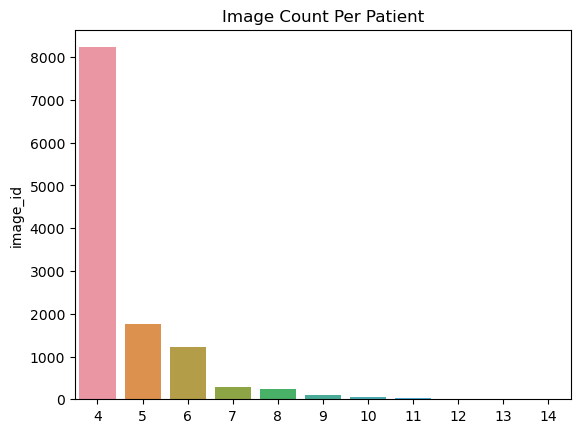

In [15]:
# plot to see the count of images taken
count_per_patient = train_df.groupby("patient_id").image_id.count()
sns.barplot(x = count_per_patient.value_counts().index, y = count_per_patient.value_counts())
plt.title("Image Count Per Patient")

We can see that **most of the patients took 4-6 mammograms.**

Though people who took more than 6 images are also present but the count of them is very less.

In [16]:
# This is total number of labels that says cancer is present
train_df['cancer'].value_counts()

0    53511
1     1158
Name: cancer, dtype: int64

Text(0.5, 1.0, 'Number of patients with cancer')

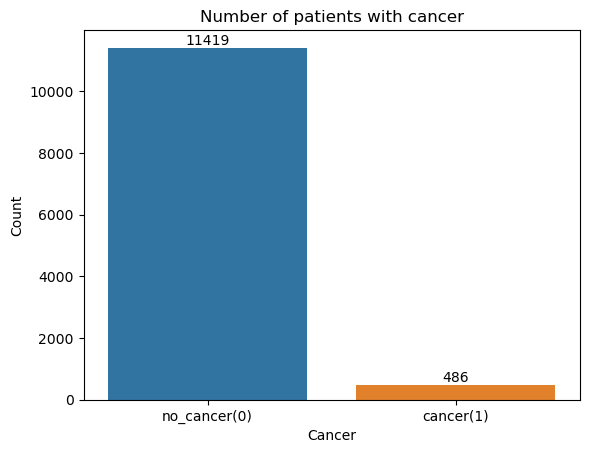

In [17]:
# Plot to see how many patients got cancer
def has_cancer(x):
    output = "no_cancer(0)"
    if x>0:
        output = "cancer(1)"
    return output

cancer_per_patient = train_df.groupby("patient_id").cancer.sum().apply(lambda x: has_cancer(x))

ax = sns.barplot(x = cancer_per_patient.value_counts().index, y = cancer_per_patient.value_counts())
ax.bar_label(ax.containers[0])
plt.xlabel("Cancer")
plt.ylabel("Count")
plt.title("Number of patients with cancer")

**High class imbalance**

We will perform **undersampling of majority class** (which is non_cancer represented by 0) before we go for model training.

Text(0.5, 1.0, 'Patient age distribution')

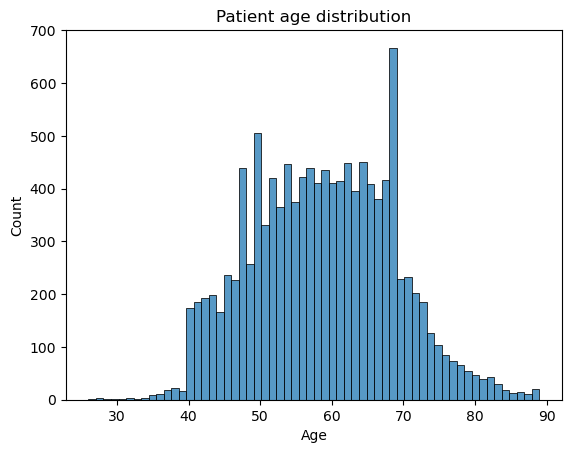

In [18]:
# Plotting a histogram to see the distribution of different age groups
def get_val(x):
    return x[0]

age_df = train_df[['age','patient_id']]
patient_age = age_df.groupby("patient_id").age.unique().apply(lambda x: get_val(x))
sns.histplot(patient_age.values, bins=60)
plt.xlabel("Age")
plt.title("Patient age distribution")

Most of the females getting a mammogram done are in the age range 40-70.

Further, we can explore the distribution of females having cancer with those not having cancer in the various age groups using the plot below.

<AxesSubplot:xlabel='age', ylabel='Cancer count(red)'>

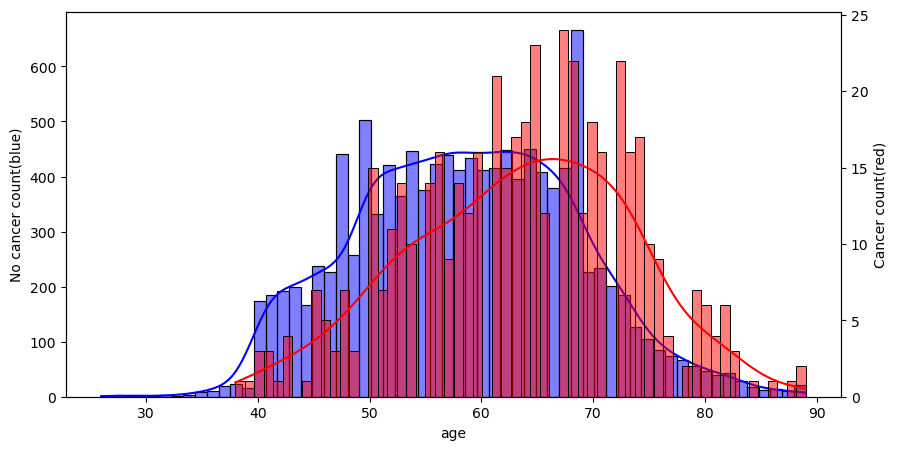

In [19]:
age_cancer = train_df.groupby(["patient_id","cancer"]).age.unique().apply(lambda x:get_val(x))
age_cancer_df = pd.DataFrame(age_cancer).reset_index()

fig,ax = plt.subplots(figsize=(10,5))
sns.histplot(age_cancer_df[age_cancer_df["cancer"] == 0]["age"], color="b",bins=60,kde=True,ax=ax)
ax.set_ylabel("No cancer count(blue)")

ax2 = ax.twinx()
ax2.set_ylabel("Cancer count(red)")
sns.histplot(age_cancer_df[age_cancer_df["cancer"] == 1]["age"], color="r", bins=60, kde=True, ax=ax2)

There are 171 (1.4%) patients having implant.


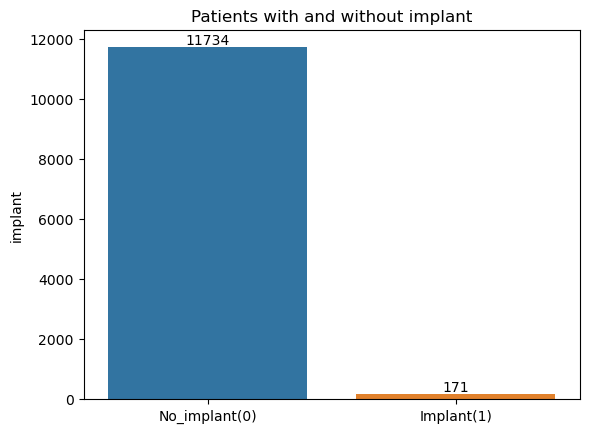

In [20]:
# Checking the count of females with implants having cancer
patient_implant = train_df.groupby("patient_id").implant.max()
ax = sns.barplot(x = patient_implant.value_counts().index, y = patient_implant.value_counts())
ax.bar_label(ax.containers[0])
plt.title("Patients with and without implant")
ax.set_xticklabels(["No_implant(0)", "Implant(1)"])

patient_with_implant = len(patient_implant[patient_implant.values>0])
print(f"There are {patient_with_implant} ({round(100*patient_with_implant/patient_num, 1)}%) patients having implant.")

Text(0.5, 1.0, 'Which machine was most used for diagnosing cancer...?')

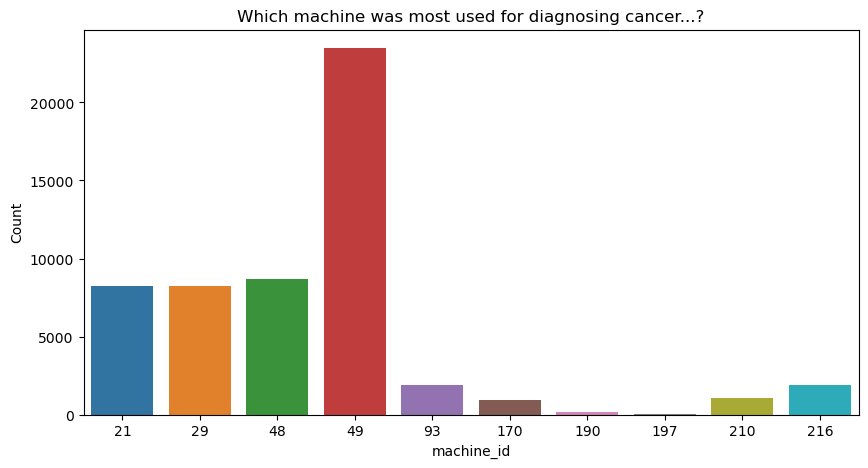

In [21]:
# plot to see which machine was most used for diagnosing cancer. 
machine_df = train_df.groupby("machine_id").count()["patient_id"].reset_index()
plt.figure(figsize=(10,5))
sns.barplot(x="machine_id", y="patient_id", data=machine_df)
plt.ylabel("Count")
plt.title("Which machine was most used for diagnosing cancer...?")

**Machine 49** was **used the most** for diagnosing cancer. 

Machine 21, 29, and 48 were used almost equally.

The following plot illustrates (in percentage) the cancer cases found on the above machines.

Text(0.5, 1.0, 'Percentage of cancer detected on the machines')

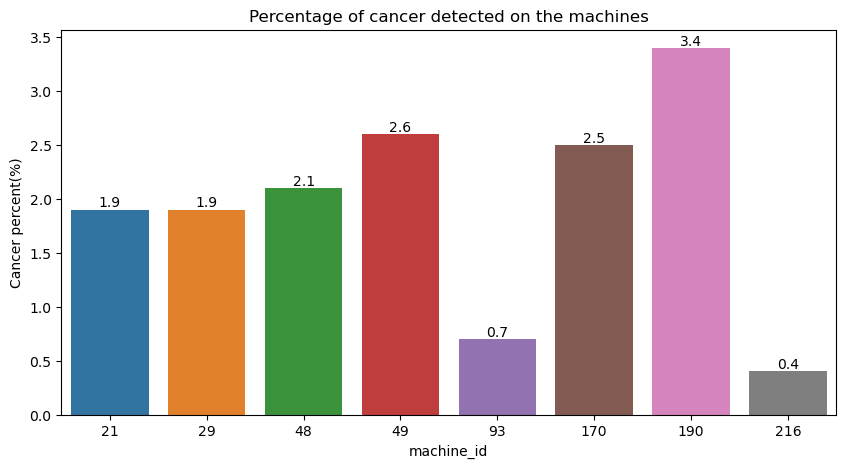

In [22]:
machine_cancer_df = train_df.groupby(["machine_id", "cancer"]).count()["patient_id"].reset_index()
total_machine_df = machine_cancer_df.groupby("machine_id").sum().reset_index()
machine_cancer_percent = machine_cancer_df.merge(total_machine_df, on="machine_id")
machine_cancer_percent["cancer_percent"] = round(100.0*machine_cancer_percent["patient_id_x"]/machine_cancer_percent["patient_id_y"],1)
cancer_percent = machine_cancer_percent[machine_cancer_percent["cancer_x"]==1]
plt.figure(figsize=(10,5))
ax = sns.barplot(x="machine_id", y="cancer_percent", data=cancer_percent)
ax.bar_label(ax.containers[0])
plt.ylabel("Cancer percent(%)")
plt.title("Percentage of cancer detected on the machines")

Cancer detected on machine 21, 29, 48, 49 is around **2% ~ 2.5%** which is quite close. 

One might get mistaken by the thing that machine 190 detects highest cancer. In real, machine 190 had 1 or very few patients, therefore the cancer detection seems high.

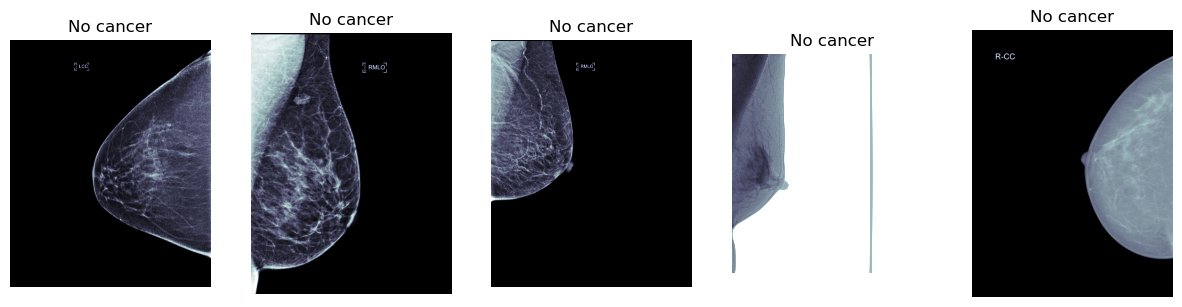

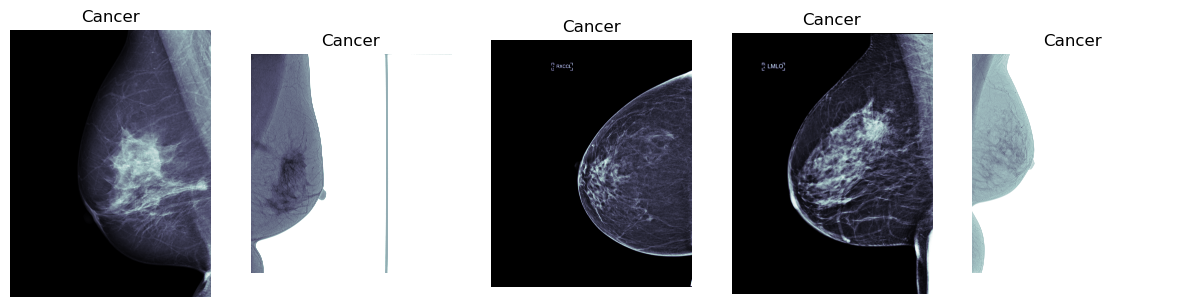

In [23]:
# Plotting images with and without cancer. Reference https://www.kaggle.com/code/dingyan/rsna-eda-pca-logistic-regression

image_no_cancer = train_df[train_df["cancer"]==0]
image_cancer = train_df[train_df["cancer"]==1]

# Paths to image data
train_images_path = "/kaggle/input/rsna-breast-cancer-detection/train_images/"
test_images_path = "/kaggle/input/rsna-breast-cancer-detection/test_images/"

def get_image_path(image_df, n):
    ids = image_df[["patient_id", "image_id"]].sample(n, random_state=42)
    paths = []
    for i in range(len(ids)):
        path = os.path.join(train_images_path, str(ids["patient_id"].values[i]), str(ids["image_id"].values[i])+'.dcm')
        paths.append(path)
    return paths

n = 5
no_cancer_paths = get_image_path(image_no_cancer, n)
cancer_paths = get_image_path(image_cancer, n)

plt.figure(figsize=(15, 8))

for j in range(n):
    plt.subplot(1, n, j+1)
    im = dicomsdl.open(no_cancer_paths[j])
    plt.imshow(im.pixelData(storedvalue=False), cmap='bone') 
    plt.grid(False)
    plt.title(f"No cancer")
    plt.axis("off")
plt.show()
plt.figure(figsize=(15, 8))

for j in range(n):
    plt.subplot(1, n, j + 1)
    im = dicomsdl.open(cancer_paths[j])
    plt.imshow(im.pixelData(storedvalue=False), cmap='bone')
    plt.grid(False)
    plt.title(f"Cancer")
    plt.axis("off")
plt.show()
fig.tight_layout()

# Define functions and classes - preprocessing, model

## Important points

1. Offset correction is important to do so that the range of pixel values in the image starts from zero. This is done by subtracting the minimum pixel value of the image from every pixel.
2. After offset correction we normalize our pixel values so that they lie in the range of 0 to 1. This makes it easier to work with subsequent steps.
3. Some of the images can be inverted. If the X-ray image is in "MONOCHROME1" format, then it needs to be inverted so that the darkest pixels become the lightest and vice versa. This is done by subtracting the maximum pixel value in the image from every pixel.
4. We perform min max scaling so as to ensure that after the inversion correction, the pixel values are still in the range of 0 to 1.
5. We then convert the pre-processed image to 8 bit grayscale image to reduce the memory requirements of the image. This make it easier to work with the subsequent steps.
6. Honestly, I am not sure how people arrived at a value of 5 for image cropping. But, here is the reference where I first saw this https://www.kaggle.com/code/atshimamura/jpn-getting-started-with-keras-low-score/notebook


In [24]:
"""
The function below reads a dicom file, performs the offset correction, fix any inverted images and
finally performs min max scaling. 
"""

def normalize_xray(path, fix_monochrome = True):
    dicom = dicomsdl.open(path)
    dicom_arr = dicom.pixelData(storedvalue=False)  # storedvalue = True for int16 return otherwise float32    
    #offset correction
    dicom_arr = dicom_arr - np.min(dicom_arr)    
    dicom_arr = dicom_arr / np.max(dicom_arr)    
    # fix the inversion
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        dicom_arr = np.amax(dicom_arr) - dicom_arr    
    # Min Max Scaling
    dicom_arr = dicom_arr - np.min(dicom_arr)
    dicom_arr = dicom_arr / np.max(dicom_arr)
    dicom_arr = (dicom_arr * 255).astype(np.uint8) # convert to 8-bit grayscale image
    return dicom_arr

"""
Some images have unnecessary borders, so we remove them using the
function below.
"""
def crop_and_resize(image, crop_size=5):
    image = image[crop_size:-crop_size, crop_size:-crop_size]
    image = cv2.resize(image, target_size[::-1], cv2.INTER_LINEAR)
    return image

"""
This function calls the normalization function and crop image function defined above.
"""
def preprocess_images(file_path):
    image = normalize_xray(file_path)
    h, w = image.shape[:2]  # take the height and width
    image = crop_and_resize(image)
    sub_path = file_path.split("/",4)[-1].split('.dcm')[0] + '.png'
    infos = sub_path.split('/')
    pid = infos[-2]
    iid = infos[-1]; iid = iid.replace('.png','')
    return pid, iid, h, w, image

"""
The function below defines our competition evaluation metric - probablistic f1 score
https://www.kaggle.com/code/awsaf49/metric-probabilistic-fscore-tf-torch-numpy
"""
def pfbeta_torch(labels, preds, beta=1):
    preds = preds.clip(0, 1)
    y_true_count = labels.sum()
    ctp = preds[labels==1].sum()
    cfp = preds[labels==0].sum()
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0.0

In [25]:
"""
The code below defines a custom PyTorch dataset called "MyDataset" for training/validation purposes.

The __init__ method initializes the dataset with a Pandas DataFrame containing the path to DICOM files and
their corresponding cancer labels. It also takes an optional transform argument that can be used to apply 
transformations to the images.

The __len__ method returns the length of the dataset, which is the number of samples in the DataFrame.

The __getitem__ method returns a single sample from the dataset at the given index.
It first retrieves the cancer label and DICOM file path from the DataFrame.
It then preprocesses the DICOM file by extracting the patient ID, image ID, height, width, and pixel array
using the preprocess_images function. The pixel array is then converted into a PIL Image object and transformed
(if a transform was specified) before being returned as a dictionary containing the cancer label and the transformed image tensor.
"""

class MyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        cancer = row['cancer']
        cancer = torch.tensor(cancer, dtype=torch.long) 
        
        path = row['dcm_path']
        path_parts = path.split('/')
        filename = path_parts[-1]
        full_path = os.path.join('/'.join(path_parts[:-1]), filename)
        
        # Read the DICOM file and preprocess it
        pid, iid, h, w, img = preprocess_images(full_path)
        
        img = Image.fromarray(img).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return {'cancer': cancer, 'images': img} 
    
"""
This is a class for creating a PyTorch dataset for testing purpose. The class takes a DataFrame 
as an input, which contains information about the test images. The __init__ function initializes the dataset
by storing the DataFrame and any transform to be applied to the images during training or inference.

The __len__ function returns the number of items in the dataset.

The __getitem__ function is called when an item is accessed by index. It retrieves the corresponding row from
the DataFrame, extracts the path to the image, reads and preprocesses the image, applies any transforms, and
returns the patient ID and image.

"""

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        path = row['dcm_path']
        path_parts = path.split('/')
        patient_id = path_parts[-2]
        filename = path_parts[-1]
        full_path = os.path.join('/'.join(path_parts[:-1]), filename)
        # Read the DICOM file and preprocess 
        pid, iid, h, w, img = preprocess_images(full_path)
        img = Image.fromarray(img).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return patient_id, img

## Helpful points

This is a PyTorch model defined as a subclass of nn.Module. The model is called PretrainedBinaryClassifier and it uses a pre-trained EfficientNet model for binary classification.
The efficientnet-b0 architecture used in this model has a total of 20 layers, including a stem convolutional layer, a sequence of 5 blocks of convolutional layers with increasing depth and width, and a global average pooling layer. The number of channels in each block increases while the resolution decreases, resulting in feature maps with progressively larger receptive fields. The final output of the model is a linear layer that produces a single scalar value, which is used as the input to the sigmoid activation function for binary classification.

1. super(PretrainedBinaryClassifier, self).__init__(): This line calls the constructor of the parent class nn.Module to properly initialize the model.

2. self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1, weights_path="/kaggle/input/model-files/efficientnet-b0-355c32eb.pth"): This line loads the pre-trained EfficientNet model with the architecture efficientnet-b0 from the torchvision.models library, and sets the number of output classes to 1 for binary classification. The weights_path argument specifies the path to the pre-trained weights file.

3. def forward(self, x):: This function defines the forward pass of the model. It takes an input tensor x and returns the output tensor.

4. x = self.model(x): This line passes the input tensor x through the pre-trained EfficientNet model, producing an output tensor.

5. x = torch.sigmoid(x): This line applies a sigmoid function to the output tensor to squash its values between 0 and 1, which is appropriate for binary classification.

6. return x: This line returns the output tensor, which contains the binary classification scores for each input image.

For the data augmentation part, I tried some horizontal flips as follows

transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

But, in hope of getting better results I copied the augmentation of 3rd place solution (https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/391779)

In [26]:
"""
Defining my model class.
For this competition I am using EfficientNet pre-trained model
"""

class PretrainedBinaryClassifier(nn.Module):
    def __init__(self):
        super(PretrainedBinaryClassifier, self).__init__()
        # Load the pre-trained EfficientNet model
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1, weights_path="/kaggle/input/model-files/efficientnet-b0-355c32eb.pth")
        
    def forward(self, x):
        x = self.model(x)
        x = torch.sigmoid(x)
        return x

In [27]:
"""
One of the transformations (transforms.RandomErasing) may sometimes remove parts of the image, 
which could result in an image with one or more dimensions being zero. When this happens, the transforms.ToTensor() operation fails,
because it expects the image to have at least one non-zero dimension.

To solve this we first convert the PIL image to a tensor and then apply the transforms.RandomErasing() before normalizing. 
With this approach, the transforms.RandomErasing() is applied to the tensor representation of the image rather than the PIL image, 
so it won't cause issues with the transforms.ToTensor() operation.
"""
class ToTensorWithErasing(object):
    def __call__(self, img):
        img_tensor = transforms.functional.to_tensor(img)
        img_tensor = transforms.RandomErasing(p=0.5, scale=(0.1, 0.5), ratio=(0.3, 3.3))(img_tensor)
        return img_tensor

"""
Defining our transformations for train, validation and test sets. 
We don't perform data augmentation on validation sets.

https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/391779
"""

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=45, translate=(0.3, 0.3), scale=(0.7, 1.3)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.7),
    ToTensorWithErasing(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([transforms.ToTensor()])

# Create training and validation sets

## Undersampling

In [28]:
# set seed for reproducibility
random_seed = 534
train_subset_0 = train_df[train_df.cancer == 0].sample(n = 460, random_state=random_seed) #460
train_subset_1 = train_df[train_df.cancer == 1].sample(n = 360, random_state=random_seed) # 360
train_combined = pd.concat([train_subset_0, train_subset_1])

print(train_combined.shape)
print(train_combined.cancer.value_counts())
train_combined.reset_index(inplace=True)

# train test split
training_set, validation_set = train_test_split(train_combined, test_size=0.2, random_state=276)
print(training_set.shape)
print(validation_set.shape)

(820, 16)
0    460
1    360
Name: cancer, dtype: int64
(656, 17)
(164, 17)


# Create pytorch training and validation datasets

In [29]:
%%time

train_dataset = MyDataset(training_set, transform = train_transform) 
val_dataset = MyDataset(validation_set, transform = val_transform) 

CPU times: user 15 µs, sys: 2 µs, total: 17 µs
Wall time: 37 µs


In [30]:
print("Checking if pytorch datasets get created...")
if len(train_dataset) > 0:
    print("The training dataset contains", len(train_dataset), "samples.")
else:
    print("The training dataset is empty.")
    
if len(val_dataset) > 0:
    print("The val dataset contains", len(val_dataset), "samples.")
else:
    print("The val dataset is empty.")

Checking if pytorch datasets get created...
The training dataset contains 656 samples.
The val dataset contains 164 samples.


In [31]:
print("Checking if transformation is applied")
print("Training dataset transform is: ", train_dataset.transform)
print("Validation dataset transform is:", val_dataset.transform)

Checking if transformation is applied
Training dataset transform is:  Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
    RandomAffine(degrees=[-45.0, 45.0], translate=(0.3, 0.3), scale=(0.7, 1.3))
    RandomPerspective(p=0.7)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Validation dataset transform is: Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


# Create train and val data loaders

In [32]:
%%time

"""
num_workers=1 implies that one additional worker process will be created to
load the data in parallel with the main process.
"""

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 1)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

CPU times: user 295 µs, sys: 40 µs, total: 335 µs
Wall time: 340 µs


In [33]:
"""
Number of batches = len(train_dataset)/batch_size. For e.g.: - 264/64 = 4.125 which means
4 full batches and 0.125 extra batch in order to read all the 264 training samples.
So these 4.125 batches are passed through each epoch. The weights are updated after each epoch and
the model continues to learn.
"""

print("Number of training batches",len(train_loader)) 
print("Number of validation batches",len(val_loader))

Number of training batches 41
Number of validation batches 11


# Create an instance of model, train and evaluate it

In [34]:
# Checking if gpu is available
print(torch.cuda.is_available())
# print the number of available GPUs on the current system. If no GPUs are available, it would print 0.
print(torch.cuda.device_count()) 

True
2


## Useful points

nn.BCEWithLogitsLoss() is a PyTorch loss function that is commonly used for binary classification problems. It combines the binary cross-entropy (BCE) loss and the sigmoid activation function into a single function that is more numerically stable and efficient to compute.


In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = PretrainedBinaryClassifier()
# Move the model to the GPU device if it is available
model.to(device)

# Define loss function https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
criterion = nn.BCEWithLogitsLoss() 
criterion = criterion.cuda() # move to GPU 

learning_rate = 0.0001
weight_decay = 0.01

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Loaded pretrained weights for efficientnet-b0


In [36]:
# ! pip install torchsummary
# from torchsummary import summary
# # Display the model summary
# summary(model, input_size=(3, 224, 224))

In [37]:
%%time

# Train the model for multiple epochs
train_losses = []
train_acc_metric = []
train_pf1_metric = []

val_losses = []
val_acc_metric = []
val_pf1_metric = []

for epoch in range(num_epochs):
    # Train
    running_train_loss = 0.0
    running_train_acc = 0.0
    running_train_pf1 = 0
    
    model.train() # set the model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, targets = data['images'], data['cancer']
        targets = targets.view(-1, 1) # Reshape the target tensor to (batch_size, 1)
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute loss
        loss = criterion(outputs, targets.float())
        
        # Compute training accuracy
        predicted = torch.round(torch.sigmoid(outputs))
        correct = (predicted == targets).sum().item()
        accuracy = correct / targets.size(0)
        # Compute pf1 metric
        pf1_metric = pfbeta_torch(targets.cpu().numpy(), torch.sigmoid(outputs).detach().cpu().numpy())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss and metric for the epoch
        running_train_loss += loss.item()
        running_train_acc += accuracy
        running_train_pf1 += pf1_metric

    # Compute and print average loss and metrics for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_acc = running_train_acc / len(train_loader)
    avg_train_pf1 = running_train_pf1 / len(train_loader)
    train_losses.append(avg_train_loss)
    train_acc_metric.append(avg_train_acc) # train_metrics
    train_pf1_metric.append(avg_train_pf1)
    print('Epoch %d, avg training loss: %.3f, avg training accuracy: %.3f, avg training pf1: %.3f'%
          (epoch + 1, avg_train_loss, avg_train_acc, avg_train_pf1))


    # Validate
    model.eval() # set the model to evaluation mode
    running_val_loss = 0.0
    running_val_acc = 0.0
    running_val_pf1 = 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, targets = data['images'], data['cancer']
            targets = targets.view(-1, 1) # Reshape the target tensor to (batch_size, 1)
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets.float())

            # Compute validation accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            correct = (predicted == targets).sum().item()
            accuracy = correct / targets.size(0)
            
            # Compute pf1 metric
            pf1_metric = pfbeta_torch(targets.cpu().numpy(), torch.sigmoid(outputs).detach().cpu().numpy())

            # Accumulate loss and metric for the epoch
            running_val_loss += loss.item()
            running_val_acc += accuracy
            running_val_pf1 += pf1_metric

    # Compute and print average loss and accuracy for validation set
    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_acc = running_val_acc / len(val_loader)
    avg_val_pf1 = running_val_pf1 / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc_metric.append(avg_val_acc)
    val_pf1_metric.append(avg_val_pf1)
    print('Epoch %d, avg validation loss: %.3f, avg validation accuracy: %.3f, avg validation pf1: %.3f' %
          (epoch + 1, avg_val_loss, avg_val_acc, avg_val_pf1))

Epoch 1, avg training loss: 0.750, avg training accuracy: 0.442, avg training pf1: 0.503
Epoch 1, avg validation loss: 0.762, avg validation accuracy: 0.415, avg validation pf1: 0.486
Epoch 2, avg training loss: 0.737, avg training accuracy: 0.442, avg training pf1: 0.500
Epoch 2, avg validation loss: 0.753, avg validation accuracy: 0.415, avg validation pf1: 0.481
Epoch 3, avg training loss: 0.726, avg training accuracy: 0.442, avg training pf1: 0.490
Epoch 3, avg validation loss: 0.750, avg validation accuracy: 0.415, avg validation pf1: 0.480
Epoch 4, avg training loss: 0.714, avg training accuracy: 0.442, avg training pf1: 0.485
Epoch 4, avg validation loss: 0.743, avg validation accuracy: 0.415, avg validation pf1: 0.478
Epoch 5, avg training loss: 0.708, avg training accuracy: 0.442, avg training pf1: 0.485
Epoch 5, avg validation loss: 0.739, avg validation accuracy: 0.415, avg validation pf1: 0.477
Epoch 6, avg training loss: 0.706, avg training accuracy: 0.442, avg training pf

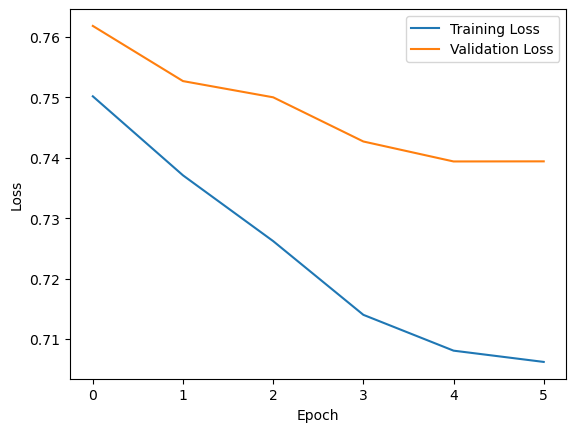

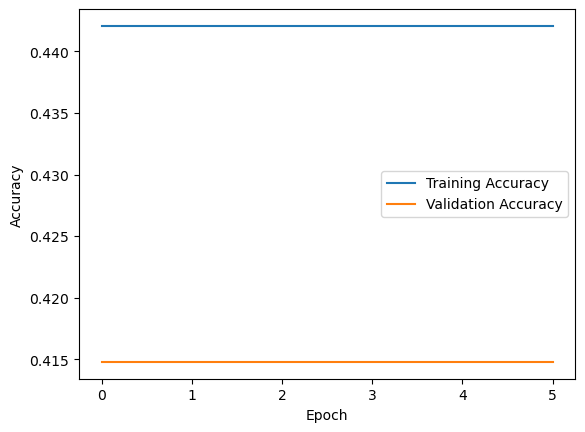

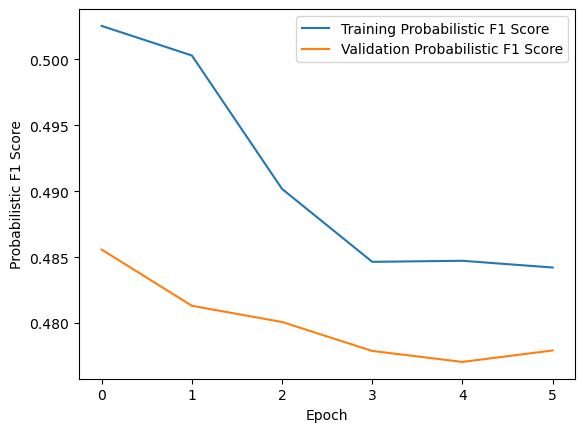

In [38]:
# Plot the learning curves 

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_acc_metric, label='Training Accuracy')
plt.plot(val_acc_metric, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_pf1_metric, label='Training Probabilistic F1 Score')
plt.plot(val_pf1_metric, label='Validation Probabilistic F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Probabilistic F1 Score')
plt.legend()
plt.show()

# Prediction on test set

In [39]:
%%time

"""
Just like training data, create pytorch dataset and data loader for
test data. 
"""

test_dataset = TestDataset(test_df, transform = test_transform)
test_dataloader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle=False, num_workers = 1)

CPU times: user 312 µs, sys: 38 µs, total: 350 µs
Wall time: 354 µs


In [40]:
%%time

# Initialize an empty list to store predictions
predictions = []

# Iterate through the test dataloader
for batch in test_dataloader:
    pids, images = batch
    images = images.to(device)
    
    # Forward pass
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.sigmoid(outputs)
        predictions.extend(probabilities.cpu().numpy())

CPU times: user 28.5 ms, sys: 43.2 ms, total: 71.7 ms
Wall time: 2.9 s


# Save predictions to dataframe and create submission csv file

In [41]:
def get_val(x):
    return x[0]

test_df['cancer'] = predictions
test_df['cancer'] = test_df['cancer'].apply(lambda x: get_val(x))
test_df.tail()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,dcm_path,cancer
0,2,10008,736471439,L,MLO,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/tes...,0.672650
1,2,10008,1591370361,L,CC,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/tes...,0.670596
2,2,10008,68070693,R,MLO,81,0,21,10008_R,/kaggle/input/rsna-breast-cancer-detection/tes...,0.675794
3,2,10008,361203119,R,CC,81,0,21,10008_R,/kaggle/input/rsna-breast-cancer-detection/tes...,0.664996


In [42]:
sub = test_df.groupby('prediction_id')['cancer'].mean().to_frame().reset_index()
sub.tail()

,prediction_id,cancer
0,10008_L,0.671623
1,10008_R,0.670395


In [43]:
sub.to_csv("submission.csv", index = False)

# Useful Tests

In [44]:
# """
# Code to check if the augmentations get applied correcty or not.

# Note: The images present here in the train_loader should be unaugmented one. 
# """

# for i, data in enumerate(train_loader, 0):
#     inputs, targets = data['images'], data['cancer']

#     # Convert tensor inputs to PIL Images
#     inputs_pil = [ToPILImage()(img) for img in inputs]

#     # Plot the original images
#     fig, axs = plt.subplots(1, 3, figsize=(10, 5))
#     for i in range(3):
#         axs[i].imshow(inputs_pil[i])
#         axs[i].axis('off')
#         axs[i].set_title('Original')
    
#     # Apply the transform to the images
#     images_aug = [train_transform(image) for image in inputs_pil]

#     # Plot the augmented images
#     fig, axs = plt.subplots(1, 3, figsize=(10, 5))
#     for i in range(3):
#         #axs[i].imshow(images_aug[i])
#         axs[i].imshow(images_aug[i].permute(1, 2, 0))
#         axs[i].axis('off')
#         axs[i].set_title('Augmented')
